<a href="https://colab.research.google.com/github/unicamp-dl/IA025_2022S1/blob/main/ex04/Pedro_Cintra/Exerc%C3%ADcio_Aula_4_235648.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Regressão Softmax com dados do MNIST utilizando gradiente descendente estocástico por minibatches

Este exercicío consiste em treinar um modelo de uma única camada linear no MNIST **sem** usar as seguintes funções do pytorch:

- torch.nn.Linear
- torch.nn.CrossEntropyLoss
- torch.nn.NLLLoss
- torch.nn.LogSoftmax
- torch.optim.SGD
- torch.utils.data.Dataloader

## Importação das bibliotecas

In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import random
import torch
import torchvision
from torchvision.datasets import MNIST

## Fixando as seeds

In [2]:
random.seed(123)
np.random.seed(123)
torch.manual_seed(123)

## Dataset e dataloader

### Definição do tamanho do minibatch

In [3]:
batch_size = 50

### Carregamento, criação dataset e do dataloader

In [4]:
dataset_dir = '../data/'

dataset_train_full = MNIST(dataset_dir, train=True, download=True,
                           transform=torchvision.transforms.ToTensor())
print(dataset_train_full.data.shape)
print(dataset_train_full.targets.shape)

torch.Size([60000, 28, 28])
torch.Size([60000])


### Usando apenas 1000 amostras do MNIST

Neste exercício utilizaremos 1000 amostras de treinamento.

In [5]:
indices = torch.randperm(len(dataset_train_full))[:1000]
dataset_train = torch.utils.data.Subset(dataset_train_full, indices)

In [6]:
# Escreva aqui o equivalente do código abaixo:
# loader_train = torch.utils.data.DataLoader(dataset_train, batch_size=batch_size, shuffle=False)
class DataLoader:
  def __init__(self, dataset, batch_size=batch_size, shuffle=False):
    self.dataset = list(dataset)
    self.batch_size = batch_size
    self.length = len(self.dataset)//self.batch_size + (len(self.dataset) % self.batch_size > 0)
    if shuffle == True:
      random.shuffle(self.dataset)

    self.data = list(zip(*self.dataset))
    self.data[0] = torch.stack(self.data[0], dim=0)
    self.data[1] = torch.tensor(self.data[1]).long()

  def __len__(self):
    return self.length

  def __iter__(self):
    self.index = 0
    return self

  def __next__(self): 
    if self.index < len(self):
      item1 = self.data[0][self.index*self.batch_size : self.index*self.batch_size+self.batch_size]
      item2 = self.data[1][self.index*self.batch_size : self.index*self.batch_size+self.batch_size]
      self.index += 1
      return item1, item2
    else:
      raise StopIteration

loader_train = DataLoader(dataset_train, batch_size=batch_size, shuffle=True)

In [7]:
print('Número de minibatches de trenamento:', len(loader_train))

x_train, y_train = next(iter(loader_train))
print("\nDimensões dos dados de um minibatch:", x_train.size())
print("Valores mínimo e máximo dos pixels: ", torch.min(x_train), torch.max(x_train))
print("Tipo dos dados das imagens:         ", type(x_train))
print("Tipo das classes das imagens:       ", type(y_train))

Número de minibatches de trenamento: 20

Dimensões dos dados de um minibatch: torch.Size([50, 1, 28, 28])
Valores mínimo e máximo dos pixels:  tensor(0.) tensor(1.)
Tipo dos dados das imagens:          <class 'torch.Tensor'>
Tipo das classes das imagens:        <class 'torch.Tensor'>


## Modelo

In [8]:
# Escreva aqui o codigo para criar um modelo cujo o equivalente é: 
# model = torch.nn.Linear(28*28, 10)
# model.load_state_dict(dict(weight=torch.zeros(model.weight.shape), bias=torch.zeros(model.bias.shape)))

class Model():
  def __init__(self, n_in: int, n_out: int):
    self.w = torch.zeros(n_out, n_in, requires_grad = True)
    self.b = torch.zeros(n_out, requires_grad = True)
  
  def __call__(self, x):
    y_pred = x.mm(torch.t(self.w)) + self.b.unsqueeze(0)
    return y_pred

  def parameters(self):
    return self.w , self.b

In [9]:
model = Model(28*28,10)

## Treinamento

### Inicialização dos parâmetros

In [10]:
n_epochs = 50
lr = 0.1

## Definição da Loss



\begin{align}
\mathcal{L}_{\mathrm{CE}} = \frac{1}{N} \sum_{i=1}^N y_i \log(\hat{y}_i) + (1-y_i) \log(1 - \hat{y}_i)
\end{align}

In [11]:
# Escreva aqui o equivalente de:
# criterion = torch.nn.CrossEntropyLoss()

class CrossEntropyLoss:
  def __init__(self):
    self.loss = 0

  def __call__(self,outputs, targets):   
    log_sum = torch.log(torch.sum(torch.exp(outputs), dim=1, keepdim=True))
    logits = outputs.gather(dim=1, index=targets.unsqueeze(dim=1))
    loss = torch.mean(-logits + log_sum)
    return loss

criterion = CrossEntropyLoss()

# Definição do Optimizer

In [12]:
# Escreva aqui o equivalente de:
# optimizer = torch.optim.SGD(model.parameters(), lr)

class SGD():
  def __init__(self, parameters: tuple, learning_rate: float):
    self.parameters = parameters
    self.learning_rate = learning_rate

  def step(self):
    for parameter in self.parameters:
      parameter.data -= self.learning_rate * parameter.grad

  def zero_grad(self):
    for parameter in self.parameters:
      parameter.grad = torch.zeros_like(parameter.data)

optimizer = SGD(model.parameters(), lr)

### Laço de treinamento dos parâmetros

In [13]:
epochs = []
loss_history = []
loss_epoch_end = []
total_trained_samples = 0
for i in range(n_epochs):
  # Substitua aqui o loader_train de acordo com sua implementação do dataloader.
  for x_train, y_train in loader_train:
    # Transforma a entrada para uma dimensão
    inputs = x_train.view(-1, 28 * 28)
    # predict da rede
    outputs = model(inputs)

    # calcula a perda
    loss = criterion(outputs, y_train)

    # zero, backpropagation, ajusta parâmetros pelo gradiente descendente
    # Escreva aqui o código cujo o resultado é equivalente às 3 linhas abaixo:
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    total_trained_samples += x_train.size(0)
    epochs.append(total_trained_samples / len(dataset_train))
    loss_history.append(loss.item())

  loss_epoch_end.append(loss.item())
  print(f'Epoch: {i:d}/{n_epochs - 1:d} Loss: {loss.item()}')

Epoch: 0/49 Loss: 1.192114233970642
Epoch: 1/49 Loss: 0.845406711101532
Epoch: 2/49 Loss: 0.6862918138504028
Epoch: 3/49 Loss: 0.591030478477478
Epoch: 4/49 Loss: 0.5264343619346619
Epoch: 5/49 Loss: 0.4792432487010956
Epoch: 6/49 Loss: 0.4429571032524109
Epoch: 7/49 Loss: 0.4139827787876129
Epoch: 8/49 Loss: 0.3901655673980713
Epoch: 9/49 Loss: 0.37013280391693115
Epoch: 10/49 Loss: 0.3529672920703888
Epoch: 11/49 Loss: 0.338032066822052
Epoch: 12/49 Loss: 0.32487013936042786
Epoch: 13/49 Loss: 0.3131446838378906
Epoch: 14/49 Loss: 0.3026018440723419
Epoch: 15/49 Loss: 0.2930459678173065
Epoch: 16/49 Loss: 0.28432419896125793
Epoch: 17/49 Loss: 0.27631473541259766
Epoch: 18/49 Loss: 0.26891955733299255
Epoch: 19/49 Loss: 0.2620587646961212
Epoch: 20/49 Loss: 0.25566619634628296
Epoch: 21/49 Loss: 0.24968692660331726
Epoch: 22/49 Loss: 0.244074746966362
Epoch: 23/49 Loss: 0.2387906312942505
Epoch: 24/49 Loss: 0.23380114138126373
Epoch: 25/49 Loss: 0.22907741367816925
Epoch: 26/49 Loss:

### Visualizando gráfico de perda durante o treinamento

Text(0.5, 0, 'época')

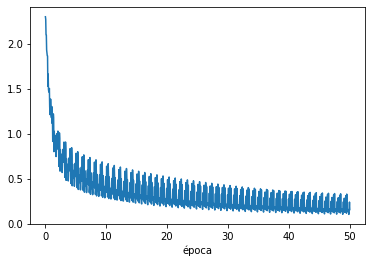

In [14]:
plt.plot(epochs, loss_history)
plt.xlabel('época')

### Visualização usual da perda, somente no final de cada minibatch

Text(0.5, 0, 'época')

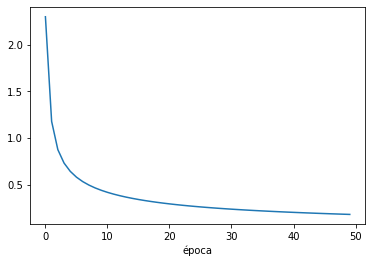

In [15]:
n_batches_train = len(loader_train)
plt.plot(epochs[::n_batches_train], loss_history[::n_batches_train])
plt.xlabel('época')

In [ ]:
# Assert do histórico de losses
target_loss_epoch_end = np.array([
    1.1979684829711914,
    0.867622971534729,
    0.7226786613464355,
    0.6381281018257141,
    0.5809749960899353,
    0.5387411713600159,
    0.5056464076042175,
    0.4786270558834076,
    0.4558936357498169,
    0.4363219141960144,
    0.4191650450229645,
    0.4039044976234436,
    0.3901679515838623,
    0.3776799440383911,
    0.3662314713001251,
    0.35566139221191406,
    0.34584277868270874,
    0.33667415380477905,
    0.32807353138923645,
    0.31997355818748474,
    0.312318354845047,
    0.3050611615180969,
    0.29816246032714844,
    0.29158851504325867,
    0.28531041741371155,
    0.2793029546737671,
    0.273544579744339,
    0.2680158317089081,
    0.26270008087158203,
    0.2575823664665222,
    0.25264936685562134,
    0.24788929522037506,
    0.24329163134098053,
    0.23884665966033936,
    0.23454584181308746,
    0.23038141429424286,
    0.22634628415107727,
    0.22243399918079376,
    0.2186385989189148,
    0.21495483815670013,
    0.21137762069702148,
    0.20790249109268188,
    0.20452524721622467,
    0.20124195516109467,
    0.19804897904396057,
    0.1949428766965866,
    0.19192075729370117,
    0.188979372382164,
    0.18611609935760498,
    0.1833282858133316])

assert np.allclose(np.array(loss_epoch_end), target_loss_epoch_end, atol=1e-6)

## Exercício 

Escreva um código que responda às seguintes perguntas:

Qual é a amostra classificada corretamente, com maior probabilidade?

Qual é a amostra classificada erradamente, com maior probabilidade?

Qual é a amostra classificada corretamente, com menor probabilidade?

Qual é a amostra classificada erradamente, com menor probabilidade?

In [17]:
# Escreva o código aqui:
# Inspirado na solução do Matheus Xavier para visualizar melhor os casos desejados
loader_eval = DataLoader(dataset_train, batch_size=len(dataset_train), shuffle=False)

x, y = next(iter(loader_eval))
logits = model(x.view(-1, 28 * 28))

exp_logits = torch.exp(logits)
sum_exp_logits = torch.sum(exp_logits, dim=1, keepdim=True)
softmax = (exp_logits / sum_exp_logits).detach()

y_pred = torch.argmax(softmax, dim=1)
y_proba = softmax.gather(-1, y_pred.view(-1, 1)).ravel()

corret_preditions = (y == y_pred)
wrong_predictions = (y != y_pred)

In [18]:
def plot_image_and_proba(images, probas, idx, title):
    plt.figure(figsize=(12, 6))
    x_labels = list(range(10))
    plt.subplot(121)
    plt.axis('off')
    plt.imshow(images[idx][0], cmap = 'binary')
    plt.subplot(122)
    plt.ylabel('Probabilidade', fontsize = 14)
    plt.xlabel('Classe', fontsize = 14)
    plt.bar(x_labels, probas[idx])
    for i in range(10):
      plt.text(x_labels[i], 1.01*probas[idx][i], f'{probas[idx][i]:.2f}', ha = 'center')
    plt.xticks(x_labels)
    plt.suptitle(title, fontsize = 16)
    plt.show()

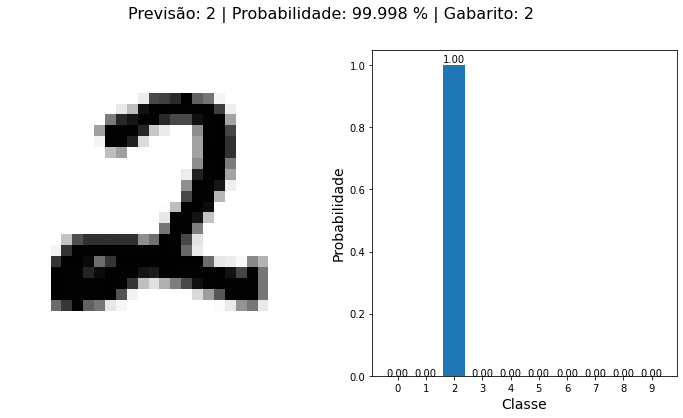

In [19]:
# Qual é a amostra classificada corretamente, com maior probabilidade?

mask = corret_preditions
idx = torch.argmax(y_proba[mask])

title = 'Previsão: {} | Probabilidade: {:.3f} % | Gabarito: {}'.format(
    y_pred[mask][idx],
    100*y_proba[mask][idx],
    y[mask][idx])
plot_image_and_proba(x[mask], softmax[mask], idx, title)

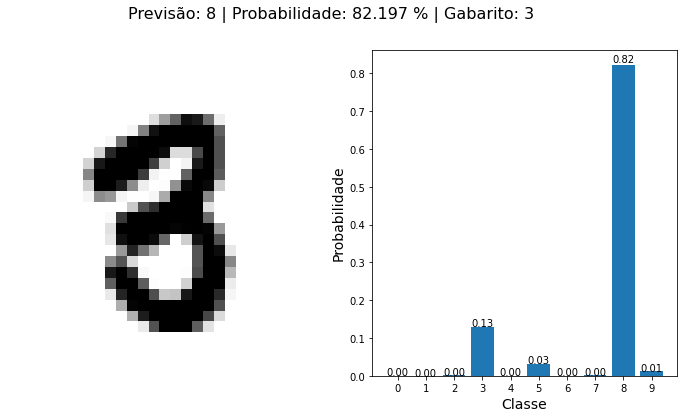

In [20]:
# Qual é a amostra classificada erradamente, com maior probabilidade?

mask = wrong_predictions
idx = torch.argmax(y_proba[mask])

title = 'Previsão: {} | Probabilidade: {:.3f} % | Gabarito: {}'.format(
    y_pred[mask][idx],
    100*y_proba[mask][idx],
    y[mask][idx])
plot_image_and_proba(x[mask], softmax[mask], idx, title)

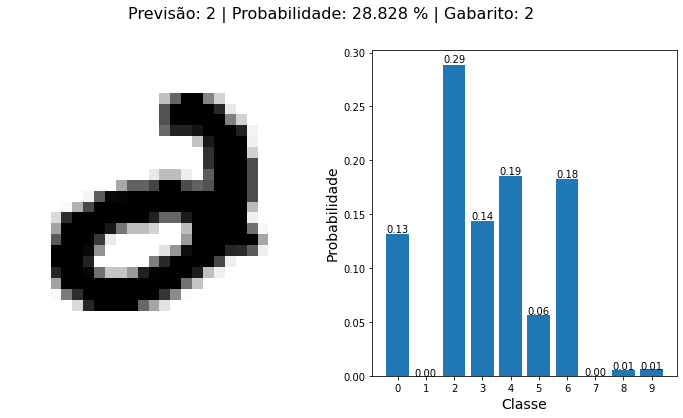

In [21]:
# Qual é a amostra classificada corretamente, com menor probabilidade?

mask = corret_preditions
idx = torch.argmin(y_proba[mask])

title = 'Previsão: {} | Probabilidade: {:.3f} % | Gabarito: {}'.format(
    y_pred[mask][idx],
    100*y_proba[mask][idx],
    y[mask][idx])
plot_image_and_proba(x[mask], softmax[mask], idx, title)

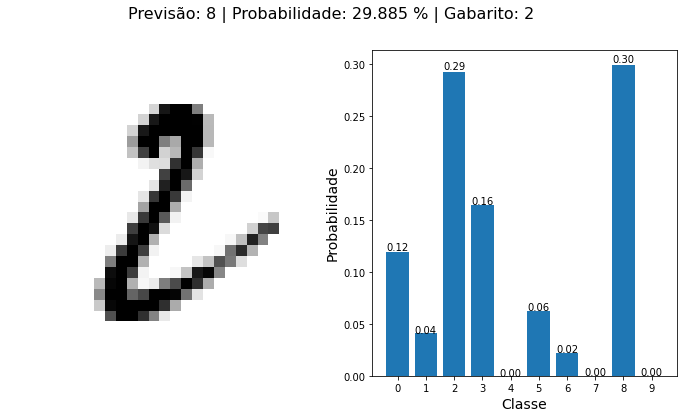

In [22]:
# Qual é a amostra classificada erradamente, com menor probabilidade?

mask = wrong_predictions
idx = torch.argmin(y_proba[mask])

title = 'Previsão: {} | Probabilidade: {:.3f} % | Gabarito: {}'.format(
    y_pred[mask][idx],
    100*y_proba[mask][idx],
    y[mask][idx])
plot_image_and_proba(x[mask], softmax[mask], idx, title)

## Exercício Bonus

Implemente um dataloader que aceite como parâmetro de entrada a distribuição probabilidade das classes que deverão compor um batch.
Por exemplo, se a distribuição de probabilidade passada como entrada for:

`[0.01, 0.01, 0.72, 0.2, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01]`

Em média, 72% dos exemplos do batch deverão ser da classe 2, 20% deverão ser da classe 3, e os demais deverão ser das outras classes.

Mostre também que sua implementação está correta.
